#질문 답변  
이 장에서는 질문 답변(QA)를 공부한다. 여러 종류의 QA가 있지만  
가장 일반적인 방법은 문서에 있는 텍스트 일부를 질문의 답으로 추출하는 추출적 QA이다.  
관련된 문서 추려내고 그 문서에서 원하는 답을 추출하는 두 단계 과정이 오늘날 QA의 시초이다.  
트랜스포머가 텍스트에서 의미를 추출하는 강력한 독해 모델로 동작하는지 공부한다.  


이 장에서는 추출적 QA를 공부하지만 상황에 따라 다른 종류의 QA가 적절할 때가 있다.  
커뮤니티 QA는 스택 오버플로 같은 포럼의 사용자가 생성한 질문 답변 쌍을 수집한다.  
그리고 의미 유사도 검색을 사용해 가장 잘 맞는 답을 찾아준다.  
"하늘은 왜 파란가요?"같은 개방형 질문에 한 문단 길이의 복잡한 답을 생성하도록  
만들어진 롱-폼 QA도 있다.  
아니면 테이블 데이터에도 QA를 수행할 수 있다.  
심지어 최근에는 TAPAS라는 트랜스포머 모델은 최종 답을 생성하기 위해 집계까지 한다.

In [ ]:
!pip install -qq farm-haystack[colab]==1.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.5/641.5 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 115.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.7/219.7 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 119.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 76.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.4 MB/s 

In [ ]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=7.2)

/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.20.1
Using datasets v2.12.0
Using haystack v1.7.0


In [ ]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [ ]:
# haystack의 로깅을 끕니다.
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
               "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base",
               "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# 질문 답변

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_marie-curie.png?raw=1" id="marie-curie"/>

## 리뷰 기반 QA 시스템 구축하기

### 데이터셋

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_phone.png?raw=1" id="phone"/>

이 장에서 사용할 데이터 셋은 여섯 분야의 제품과 서비스에서 10000여개의   
영어 고객 리뷰로 구성된 SubjQA이다.  
여섯 분야는 트립어드바이저, 음식점, 영화, 책, 전자 제품, 식료품이다.  
각 리뷰에는 위에 그림처럼 질문에 맞게 한 문장 이상을 사용해 답변할 정보가 있다.  
위 사진에서는 밑줄친 마지막 문장이 답으로 처리된다.

이 데이터셋의 흥미로운 점은 대부분의 질문과 답이 "주관적"이다.  
모든 리뷰가 사용자의 개인 경험에 의존한다. 따라서 사실 여부가 명확한 질문의 답을   
찾는 작업보다 어렵다.  
위의 그림에서 가장 중요한 "나쁜 품질(poor quality)"에 관한 쿼리를 입력했다.  
하지만 품질에 대한 기준은 사람마다 다르다.  
쿼리의 중요 부분이 리뷰에 전혀 나타나지 않는다.  
이는 키워드 검색이나 입력 질문을 재구성하는 간단한 방식으로는 답을 찾지 못한다는 것을 의미한다.  

In [ ]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains
#subjqa 라는 이름의 데이터가 어떤게 있는지 출력

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [ ]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")
#여기서는 전자 제품에 집중

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


In [ ]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


In [ ]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df
'''
title 각 제품에 연관된ASIN(고유 번호)
question 질문
answer.text 사람이 레이블링한 리뷰 텍스트 일부
answers.answer_start 답이 시작하는 문자 인덱스
context 고객 리뷰
출력에서보면
질문이 문법적으로 틀릴 수도 있다.
빈 answers.text 항목에는 리뷰에서 답을 찾지 못해 답변이 불가한 질문이 담겼다.
시작 인덱스와 답변 길이를 사용해 리뷰에서 답변에 해당하는 텍스트를 추출 할 수 있다.
'''

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


In [ ]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

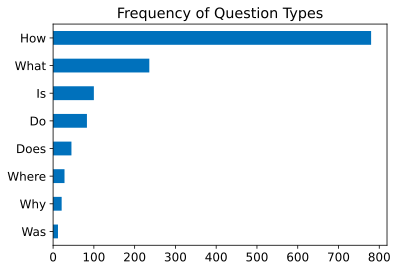

In [ ]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [ ]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### 사이드바: 스탠포드 질문 답변 데이터셋

<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-sota.png?raw=1" id="squad-sota"/>

### 사이드바 끝

### 텍스트에서 답 추출하기  
QA에서는 가장 먼저 고객 리뷰에 있는 텍스트에서 답변에 사용할 만한 부분을 식별해 찾아야한다.  
"Is it waterproof?"라는 질문에 "This watch is waterproof at 30m depth"라는 리뷰가 있다면  
모델은 "waterproof at 30m"를 출력합니다. 이를 위해 다음 방법을 이해해야 합니다.  
* 지도 학습 문제로 구성하기
* QA 작업을 위해 텍스트를 토큰화하고 인코딩하기
* 모델의 최대 문맥 크기를 초과하는 긴 텍스트 다루기

#### 범위 분류

문제를 범위 분류 작업으로 구성하는 방법은 텍스트에서 답을 추출하는 가장 일반적인 방법이다.  
모델이 예측해야 하는 레이블은 답변 범위에 해당하는 시작 토큰과 종료 토큰이다.  

<img alt="QA Head" caption="The span classification head for QA tasks" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-head.png?raw=1" id="qa-head"/>

훈련 세트가 비교적 적은 1295개 샘플만 있으므로 사전 학습된 모델을 가져오는게 좋다.  
이런 모델은 독해 능력이 우수하고 더 정확한 시스템을 구축하기 위한 좋은 기준 모델로 사용된다.  
모델을 사용해 작업에 특화된 헤드를 미세 튜닝하는 일반적인 방식과 조금 다르다.  
어차피 추출적 QA는 레이블 구조가 데이터셋에 따라 달라지지 않기 때문에 따로 헤드를 만들 필요가 없다.

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-models.png?raw=1" id="squad-models"/>

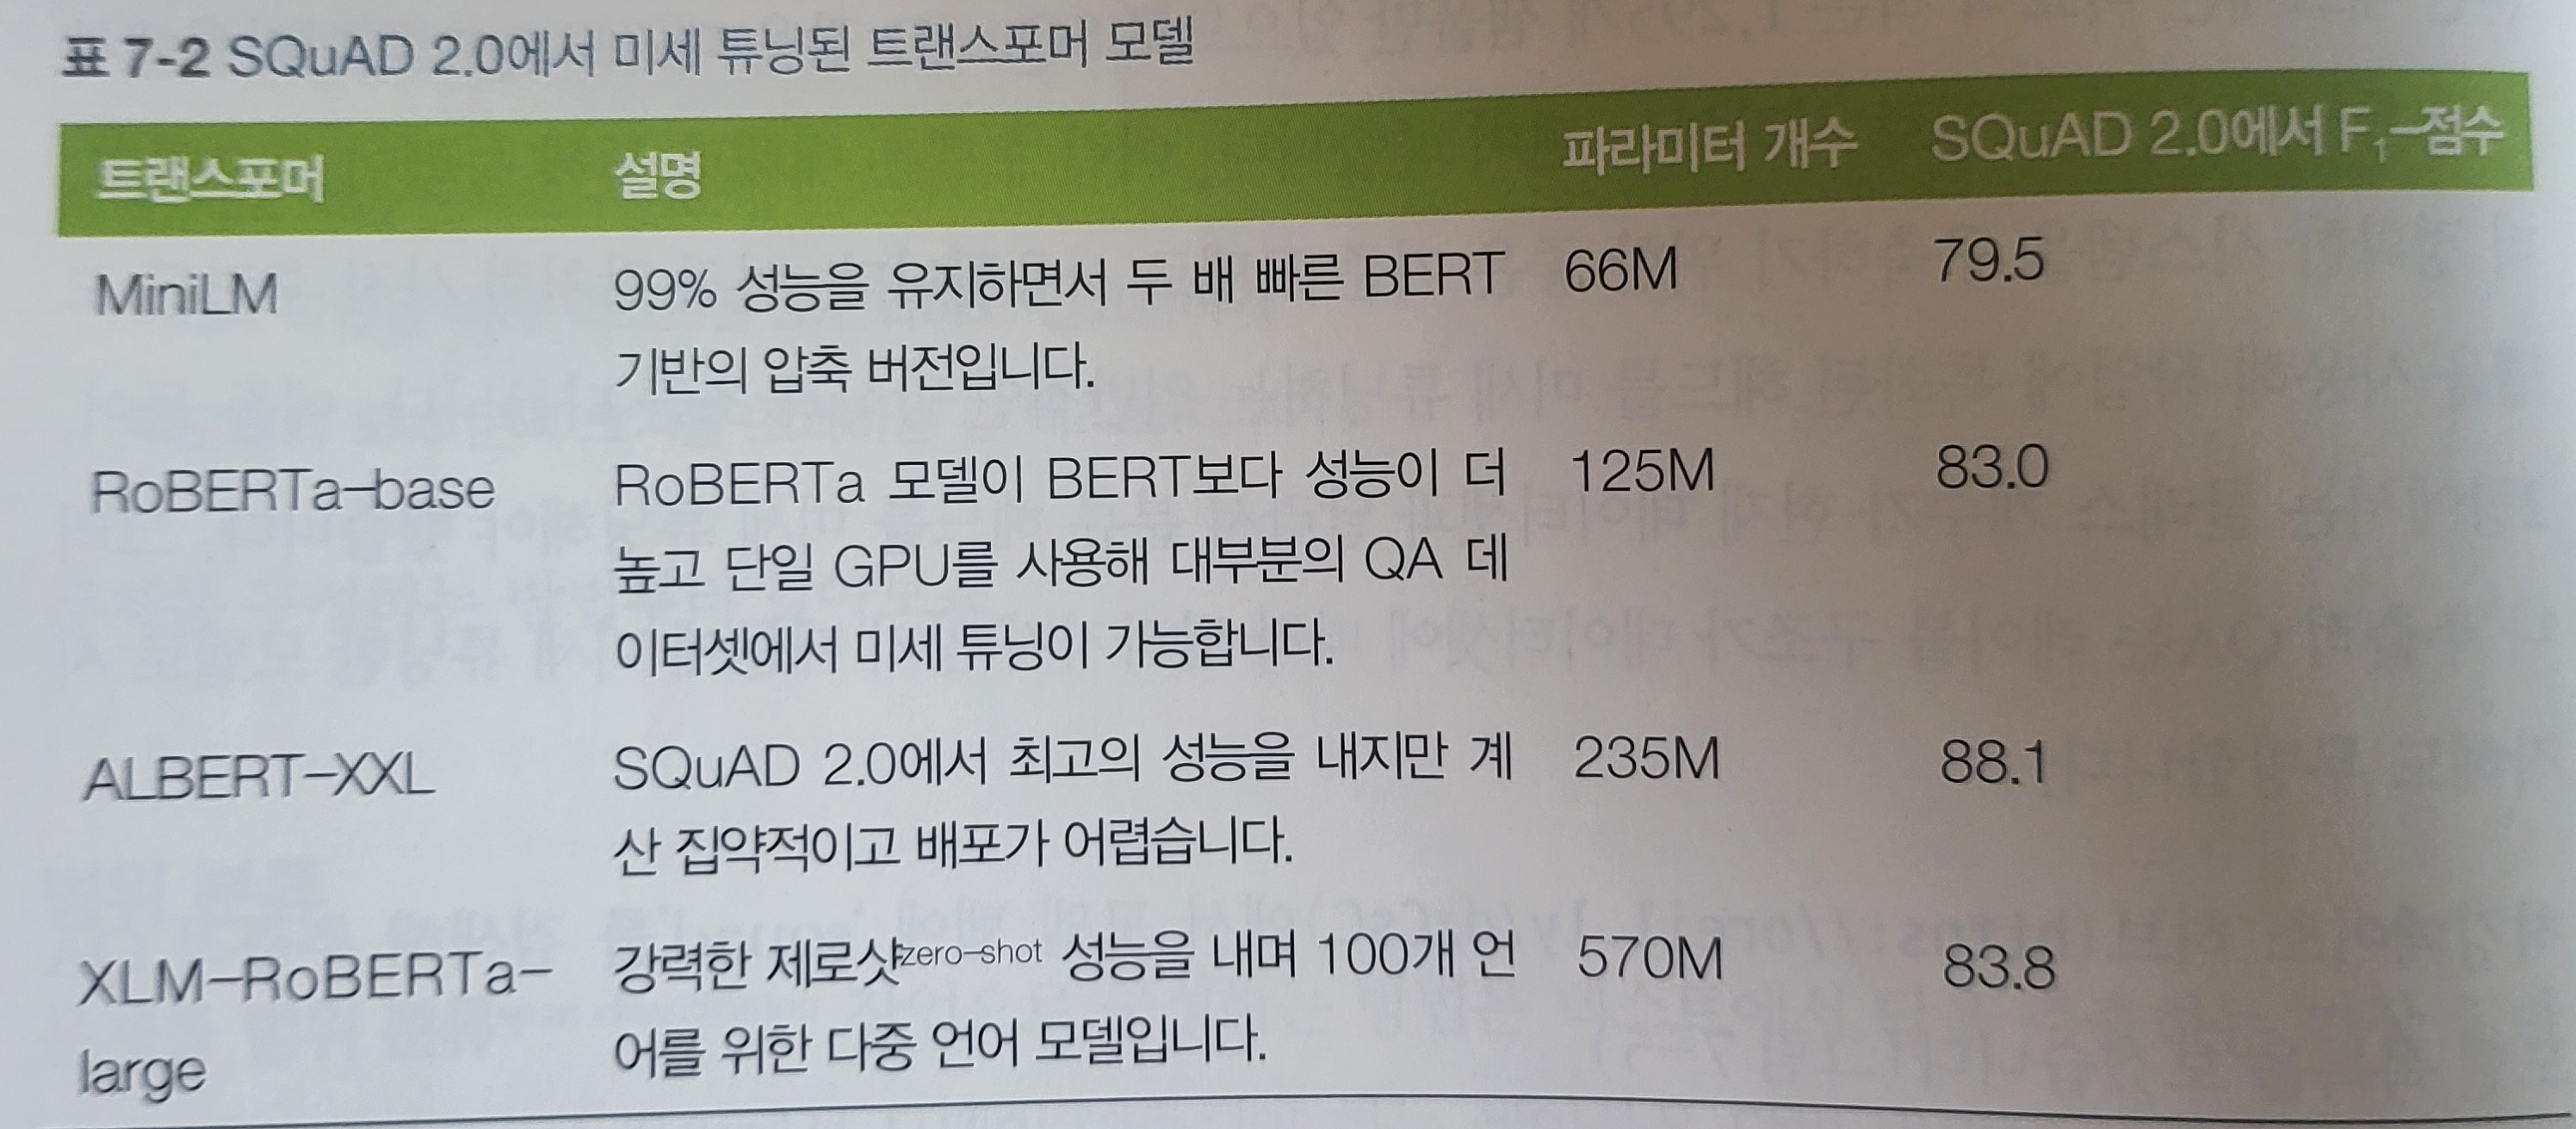

#### QA를 위한 텍스트 토큰화

In [ ]:
from transformers import AutoTokenizer
#여기서는 MiniLM을 사용 squad2에 미세 튜닝된거 가져옴
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [ ]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df
'''
input_ids은 토크나이저 해서 나온 토큰 idx 겠지
token_type_ids에서 0은 질문 토큰, 1은 문맥 토큰을 의미
'''

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


QA 샘플마다 다음 포맷으로 입력이구성됨   
[CLS] 질문 토큰 [SEP] 문맥 토큰 [SEP]  
첫 번째 [SEP] 토큰의 위치는 token_type_ids에 의해 결정된다.

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


In [ ]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [ ]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


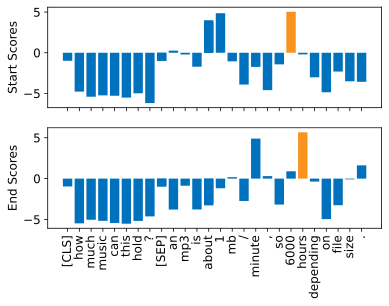

In [ ]:
# 시작 토큰과 종료 토큰에 대한 예측 로짓. 오렌지 색 토큰이 가장 높은 점수를 가진 토큰입니다.
# 이 그래프는 다음을 참고했습니다. https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold?
답변: 6000 hours


In [ ]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651616334915161, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082962095737457,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253521054983139,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [ ]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)
#답변 할수 없는 질문의 경우 이처럼 공백에 가장 큰 점수를 할당해버림

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

#### 긴 텍스트 다루기  
독해 모델의 결점 하나는 종종 문맥에 있는 토큰이 모델의 최대 시퀀스 길이를 초과 한다는 것이다.  
아래 코딩 출력 그래프를 보면 상당 부분이 512토큰에 맞지 않는 질문-문맥 쌍을 가진다.  

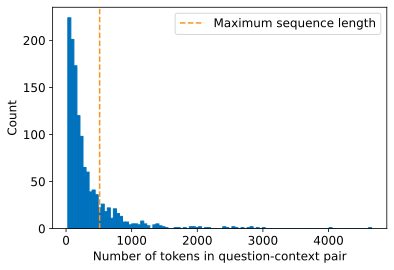

In [ ]:
# SubjQA 훈련 세트에 있는 질문-문맥 쌍의 토큰 분포
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1",
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

이럴때는 아래 그림과 같은 슬라이딩 윈도우 전략을 사용함  
최대 문맥 길이만큼 윈도우 만들고 스트라이드 만큼 건너 뛰고 다시 만들고 하는식으로  
여러개의 질문-문맥 쌍을 만들어버림

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents—the first bar corresponds to the question, while the second bar is the context captured in each window" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_sliding-window.png?raw=1" id="sliding-window"/>

In [ ]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100, #슬라이딩 윈도우 크기는 100
                              stride=25)# 25개 토큰씩 건너 뜀

In [ ]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


In [ ]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and don't feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even
after listening to music with them on all day. the sound is night and day better
than any ear - bud could be and are almost as good as the pro 4aa. they are "
open air " headphones so you cannot match the bass to the sealed types, but it
comes close. for $ 32, you cannot go wrong. [SEP]



### 헤이스택을 사용해 QA 파이프라인 구축하기  
앞의 예제에서는 질문과 문맥을 모두 모델에 제공했다. 하지만 실제로는 제품에 대한 질문만 제공한다.  
따라서 말뭉치에 있는 전체 리뷰 중 관련된 텍스트를 선택할 방법이 필요하다.  
해당 제품의 리뷰를 모두 연결해 하나의 긴 문맥으로 만들어 모델에 주입시켜 버린다.  
이방법은 간단하지만 문맥이 말도안되게 길어지면 레이턴시를 수용하지 못하는 단점이 존재  
최신 QA시스템은 "리트리버-리더" 구조를 기반으로 이 문제를 처리함

<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_retriever-reader.png?raw=1" id="retriever-reader"/>

1.   리트리버: 쿼리에서 관련도니 문서를 추출 리트리버는 일반적으로 희소 아니면 밀집으로 구분한다.  

> *   희소 리트리버: 단어 빈도를 사용해 각 문서와 쿼리를 희소 벡터로 표현, 벡터의 내적을 계산하여 관련성 결정
> *   밀집 리트리버: 인코더를 사용해 쿼리와 문서를 문맥화된 임베딩으로 표현, 쿼리의 내용을 이해해 검색 정확도 향상

2.   리더: 제공한 문서에서 답을 추출, 대개 독해 모델이지만 뒤에 자유 형식의 답변을 생성하는 모델 설명

3. 후처리: 리트리버가 추출한 문서에서 리더가 혼동을 일으키는 잡음이나 관련 없는 요소 제외  
긴 문서에 있는 여러 구절에서 정답이 나오면 종종 리더의 답을 후처리

4. 문서 저장소: 쿼리 시점에 리트리버로 제공하는 문서와 메타데이터를 저장하는 문서 전용 데이터 베이스

5. 파이프라인: 사용자 쿼리가 잘 흘러가도록 모든 구성 요소를 결합하고 여러 리트리버에서  
추출한 문서를 합치는 등의 기능을 수행

#### 문서 저장소 초기화하기
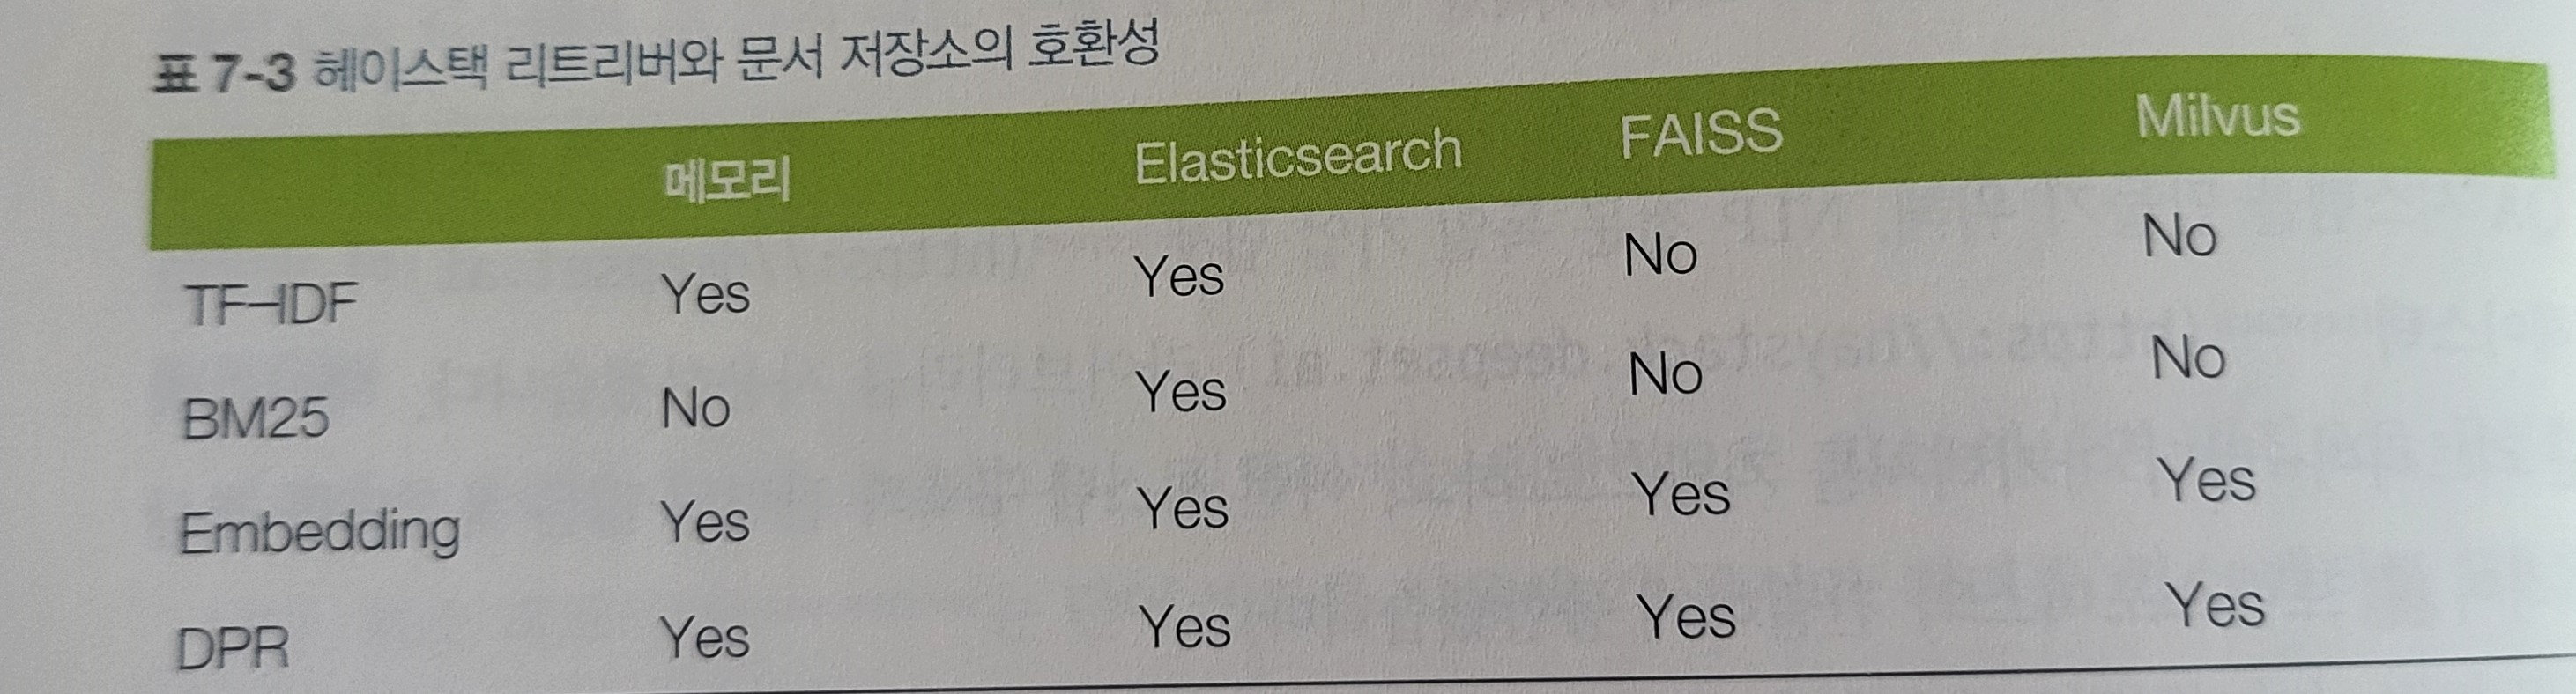

헤이스택 라이브러리에서 사용 가능한 문서 저장소는 다양하며  
저장소마다 조합할 수 있는 전용 리트리버가 있다.  
위의 2개는 희소 리트리버, 밑에 2개는 밀집 리트리버  
처음엔 양쪽 리트리버 모두 호환되는 elasticsearch를 사용  
일래스틱서치(elasticsearch)는 텍스트, 수치, 지리 데이터, 구조적 데이터, 비구조적 데이터를 포함해  
다양한 데이터 타입을 처리하는 검색엔진이다.  
대용량 데이터를 저장하고 전체 텍스트 검색으로 빠르게 필터링하므로 QA시스템 개발에 잘 맞음   

In [ ]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [ ]:
import os
from subprocess import Popen, PIPE, STDOUT

# 백그라운드 프로세스로 일래스틱서치를 실행합니다
!chown -R daemon:daemon elasticsearch-7.9.2 #이 서브 프로세스를 백그라운드에서 실행하기 위해 CHOWN 사용
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1)) #Popen 함수를 통해 새로운 프로세스 실행
# 일래스틱서치가 시작할 때까지 기다립니다
!sleep 30

subprocess 모듈은 파이썬 프로그램 내에서 새로운 프로세스를 스폰하고 여기에   
입출력 파이프를 연결하며 리턴코드를 획득할 수 있도록 하는 모듈로,  
다른 언어로   만들어진 프로그램을 통합, 제어할 수 있게 만드는 모듈이다.  
***
Popen 클래스
프로세스 생성과 관리 모듈은 내부적으로 Popen 클래스를 통해서 관리한다.  
실질적으로 call-*류의 함수들은 이 클래스를 기반으로 하고 있다. Popen은 많은  
유연성을 제공하기 때문에 기본적으로 제공되는 편의 함수들만으로 다룰 수 없는  
케이스를 커버할 때, 세밀한 옵션들에 대해서 직접 제어하고자 할 때 사용할 수 있다.

In [ ]:
# 또는 도커가 설치되어 있다면
from haystack.utils import launch_es

launch_es()

In [ ]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "408081d11c7e",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "ULnzCvGwSYC29fwD2ZCh6g",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
# document_store --> document_stores
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# 밀집 리트리버에서 사용할 문서 임베딩을 반환합니다.
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [ ]:
# 노트북을 다시 시작할 때 일래스틱서치 저장소를 모두 비우는 것이 좋습니다.
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [ ]:
for split, df in dfs.items():
    # 중복 리뷰를 제외시킵니다
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")

print(f"{document_store.get_document_count()}개 문서가 저장되었습니다")

1615개 문서가 저장되었습니다


#### 리트리버 초기화하기

헤이스택 1.4에서 `ElasticsearchRetriever`가 `BM25Retriever`로 바뀌었습니다. 여전히 버전 1.5에서 `ElasticsearchRetriever`를 사용할 수 있지만 향후 버전에서 삭제될 수 있습니다.

In [ ]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [ ]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [ ]:
print(retrieved_docs[0])

<Document: id=4a6aa9c7808ebba8d35aeecbcc3c30fe, content='This is a gift to
myself.  I have been a kindle user for 4 years and this is my third one.  I
never  ...'>


#### 리더 초기화하기

In [ ]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

In [ ]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648089170455933,
'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score':
0.5293056815862656, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}],
'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id':
'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}


#### 모두 합치기

In [ ]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

In [ ]:
n_answers = 3
preds = pipe.run(query=query,
                 params={"Retriever": {"top_k": 3, "filters": {"item_id": [item_id], "split": ["train"]}},
                                      "Reader": {"top_k": n_answers}})

print(f"질문: {preds['query']} \n")
for idx in range(n_answers):
    print(f"답변 {idx+1}: {preds['answers'][idx].answer}")
    print(f"해당 리뷰 텍스트: ...{preds['answers'][idx].context}...")
    print("\n\n")

질문: Is it good for reading?

답변 1: it is great for reading books when no light is available
해당 리뷰 텍스트: ...ecoming addicted to hers! Our son LOVES it and it is great for
reading books when no light is available. Amazing sound but I suggest good
headphones t...



답변 2: I mainly use it for book reading
해당 리뷰 텍스트: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



답변 3:
해당 리뷰 텍스트: ...None...





## QA 파이프라인 개선하기

### 리트리버 평가하기

In [ ]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [ ]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # 리트리버에서 필터링을 위해 사용하는 메타데이터
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # 답이 있는 질문을 레이블에 추가합니다
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # 답이 없는 질문을 레이블에 추가합니다
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})
        labels.append(label)

In [ ]:
print(labels[0])

<Label: {'id': 'eafdce93-db6d-4d38-8bbd-5dc513ff6f4e', 'query': 'What is the
tonal balance of these headphones?', 'document': {'content': "I have been a
headphone fanatic for thirty years and have owned and used a variety of
headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.
The Sony MDRV6 excells as the best value of any headphone that I've ever owned.
They are especially good at producing natural-sounding deep bass, and the
overall octave-to-octave balance is excellent.  The sound quality is all in all
comparable to other headphones that cost considerably more.The MDRV6 is
especially well-suited for travel due to the collapsible design, and for noisy
environments or for quiet environments such as a library where the sound emitted
by open-back headphones would distract others.The MDRV6 is not quite as
comfortable as some other headphones, but the comfort can be improved enormously
by replacing the pads with the velour pads from BeyerDynamic.  The pads tha

In [ ]:
document_store.write_labels(labels, index="label")
print(f"""{document_store.get_label_count(index="label")}개의 \
질문 답변 쌍을 로드했습니다.""")

455개의 질문 답변 쌍을 로드했습니다.


In [ ]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


In [ ]:
# 다음처럼 원하는 top_k 값으로 파이프라인을 실행할 수 있습니다
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [ ]:
print(f"재현율@3: {metrics['Retriever']['recall_single_hit']:.2f}")

재현율@3: 0.96


In [ ]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "document_id", "gold_document_ids", "gold_id_match"]]

,query,filters,rank,document_id,gold_document_ids,gold_id_match
0,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,fac2e8bec06035a70307dd1e8034ea63,[fac2e8bec06035a70307dd1e8034ea63],1.0
1,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,26bf35fe7f9a73d28535d5072ab17714,[fac2e8bec06035a70307dd1e8034ea63],0.0
0,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,9cae133919a2dc476c371cde9e5effb8,[],0.0
1,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,a1f6e39766a79f1475b3dbe07e517e04,[],0.0
2,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,0fc71a2e4ec350e845ed384717792ad8,[],0.0
0,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,47f76b8f62cf296d394d993741d660aa,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62cf296d394d993741d660aa]",1.0


In [ ]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # 최대 top_k를 계산합니다
    max_top_k = max(topk_values)
    # 파이프라인을 만듭니다
    p = DocumentSearchPipeline(retriever=retriever)
    # 테스트 세트에 있는 질문-답변 쌍을 순회하면서 최대 top_k로 추론을 실행합니다
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # 각 top_k 값에 대해 재현율을 계산합니다
    for topk in topk_values:
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(bm25_retriever)

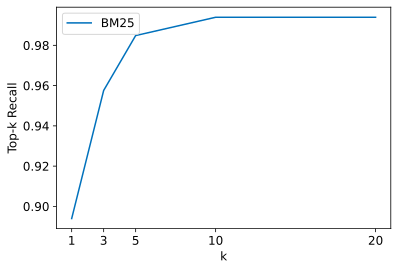

In [ ]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([bm25_topk_df], ["BM25"])

#### DPR

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_dpr.png?raw=1" id="dpr"/>

In [ ]:
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [ ]:
document_store.update_embeddings(retriever=dpr_retriever)

Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

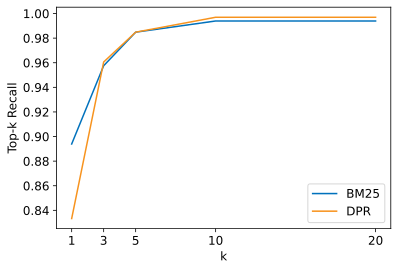

In [ ]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

### 리더 평가하기

In [ ]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [ ]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [ ]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

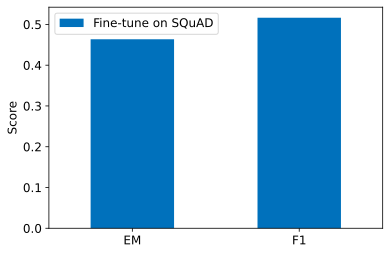

In [ ]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

### 도메인 적응

<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-schema.png?raw=1" id="squad-schema"/>

In [ ]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # 특정 문맥으로 전체 질문-답 쌍을 필터링합니다
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # qas 배열을 만듭니다
        for qid, question in id2question.items():
            # 하나의 질문 ID에 대해 필터링합니다
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # 답변 가능한 질문을 추가합니다
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # 질문-답 쌍을 qas에 추가합니다
            qas.append({"question": question, "id": qid,
                        "is_impossible": is_impossible, "answers": answers})
        # 문맥과 질문-답 쌍을 paragraphs에 추가합니다
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [ ]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

```python
[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones ...',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass is weak as expected, even with EQ adjusted up',
      'answer_start': 1302}]}],
  'context': 'To anyone who hasn\'t tried all ...'},
 {'qas': [{'question': 'How is the bass?',
    'id': '455575557886d6dfeea5aa19577e5de4',
    'is_impossible': False,
    'answers': [{'text': 'The only fault in the sound is the bass',
      'answer_start': 650}]}],
  'context': "I have had many sub-$100 headphones ..."}]
```

In [ ]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # 각 제품 ID에 대해 `paragraphs`를 만듭니다
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # 결과를 디스크에 저장합니다
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)

convert_to_squad(dfs)

In [ ]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing Dataset electronics-train.json: 100%|██████████| 1265/1265 [00:00<00:00, 12356.64 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing lo

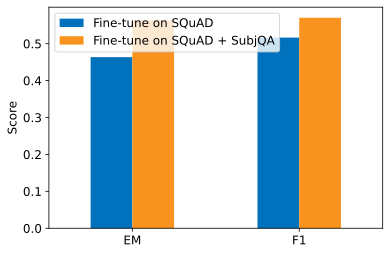

In [ ]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

In [ ]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing Dataset electronics-train.json: 100%|██████████| 1265/1265 [00:00<00:00, 12528.62 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing lo

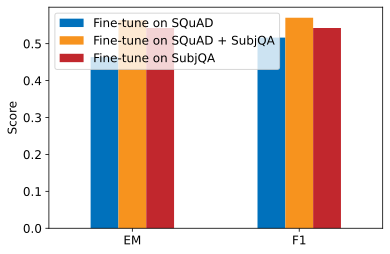

In [ ]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

### 전체 QA 파이프라인 평가하기

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# 평가하기!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 리더에서 지표를 추출합니다
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

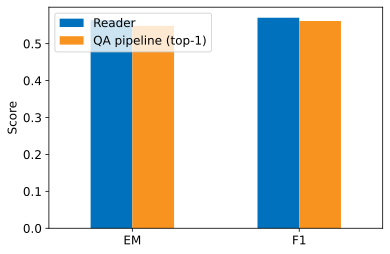

In [ ]:
# 리더와 전체 QA 파이프라인의 EM과 F1-점수 비교
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"],
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

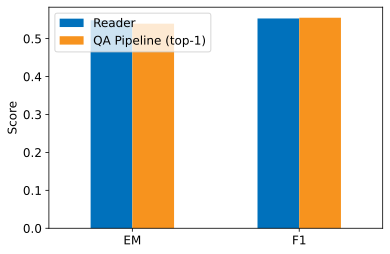

In [ ]:
# 또는 QA 파이프라인과 리더 지표를 한번에 얻습니다
# 리더 평가는 시뮬레이트된 완벽한 리트리버 결과를 사용해 두 번째로 실행됩니다
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 시뮬레이트된 완벽한 리트리버로 격리되어 실행된 리더로부터 지표를 추출합니다
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

## 추출적 QA를 넘어서

<img alt="RAG Architecture" width="600" caption="The RAG architecture for fine-tuning a retriever and generator end-to-end (courtesy of Ethan Perez)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_rag-architecture.png?raw=1" id="rag"/>

In [ ]:
from haystack.generator.transformers import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

Downloading:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

In [ ]:
from haystack.pipeline import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [ ]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query,
                     params={"Retriever": {"top_k":5,
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})
    print(f"질문: {preds['query']} \n")
    for idx in range(top_k_generator):
        # print(f"답변 {idx+1}: {preds['answers'][idx]['answer']}")
        print(f"답변 {idx+1}: {preds['answers'][idx].answer}")

In [ ]:
generate_answers(query)

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:2141: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


질문: Is it good for reading?

답변 1:  the screen is absolutely beautiful
답변 2:  the Screen is absolutely beautiful
답변 3:  Kindle fire


In [ ]:
generate_answers("What is the main drawback?")

질문: What is the main drawback?

답변 1:  the price
답변 2:  no flash support
답변 3:  the cost


## 결론

<img alt="QA Pyramid" caption="The QA hierarchy of needs" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-pyramid.png?raw=1" id="qa-pyramid"/>